Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import numpy as np
import csv

Get Image Size


In [2]:
def get_sample_image_size(dataset_dir):
    """
    dataset_dir: path to something like "Dataset/training"
                 which has subfolders (e.g., glioma_tumor, meningioma_tumor, etc.)
    returns (width, height) of the first found image
    """
    # List subfolders (the class folders)
    class_folders = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]
    
    # We assume at least one class folder and at least one image
    first_class_folder = os.path.join(dataset_dir, class_folders[0])
    image_files = [f for f in os.listdir(first_class_folder) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    first_image_path = os.path.join(first_class_folder, image_files[0])
    
    # Open the image and check size
    with Image.open(first_image_path) as img:
        width, height = img.size
        print(f"Discovered image size: {width}x{height}")
        return width, height

# Example usage:
dataset_dir = "Dataset/testing"
detected_width, detected_height = get_sample_image_size(dataset_dir)


Discovered image size: 495x619


The Model

In [3]:

########################################
# 1) Define the Model Class
########################################
class LeNet5_512_Dropout(nn.Module):
    def __init__(self, dropout_p=0.5, num_classes=4):
        """
        A LeNet-5-inspired network for 512x512 RGB images, with dropout layers.
        """
        super(LeNet5_512_Dropout, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool = nn.AvgPool2d(kernel_size=2)

        # For 512×512 input => after two (conv + pool) => shape is (16×125×125) => 250,000 features
        self.fc1 = nn.Linear(16 * 125 * 125, 120)
        self.drop1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(120, 84)
        self.drop2 = nn.Dropout(p=dropout_p)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # => (6×508×508)
        x = self.pool(x)           # => (6×254×254)
        
        x = F.relu(self.conv2(x))   # => (16×250×250)
        x = self.pool(x)           # => (16×125×125)
        
        x = x.view(x.size(0), -1)   # flatten => 16*125*125 = 250,000
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        return x


model = LeNet5_512_Dropout(dropout_p=0.5, num_classes=4)

DataLoader

In [4]:
def create_dataloaders():
    """
    Adjust these to match your dataset paths and augmentation strategies.
    """
    # Example normalization stats (like ImageNet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    

    train_transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Adjust these to match your folder structure
    train_path = "Dataset/training"
    test_path = "Dataset/testing"

    # Full training dataset
    full_train = datasets.ImageFolder(root=train_path, transform=train_transform)

    # Split into train/val (e.g., 80/20)
    train_size = int(0.8 * len(full_train))
    val_size = len(full_train) - train_size
    train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

    # Override the transform for val
    val_dataset.dataset.transform = val_test_transform

    # Test dataset
    test_dataset = datasets.ImageFolder(root=test_path, transform=val_test_transform)

    # DataLoaders
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader

Training Function

In [5]:
def train_and_evaluate(
    model, 
    train_loader, 
    val_loader, 
    test_loader,
    num_epochs=5, 
    lr=0.001, 
    weight_decay=1e-5
):
    """
    Trains the model for `num_epochs`, tracks train/val loss each epoch,
    evaluates on test at the end.

    Returns:
        trained_model, test_acc, train_losses, val_losses
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        #-------------------------
        # Training Phase
        #-------------------------
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        train_pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] (Train)")
        for images, labels in train_pbar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels).item()
            total_samples += labels.size(0)

            current_loss = running_loss / total_samples
            current_acc = running_corrects / total_samples
            train_pbar.set_postfix({"loss": f"{current_loss:.4f}",
                                    "acc": f"{current_acc:.4f}"})

        epoch_loss = running_loss / total_samples
        train_losses.append(epoch_loss)

        #-------------------------
        # Validation Phase
        #-------------------------
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        val_total_samples = 0

        val_pbar = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] (Val)")
        with torch.no_grad():
            for val_images, val_labels in val_pbar:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item() * val_images.size(0)
                val_running_corrects += torch.sum(val_preds == val_labels).item()
                val_total_samples += val_labels.size(0)

                current_val_loss = val_running_loss / val_total_samples
                current_val_acc = val_running_corrects / val_total_samples
                val_pbar.set_postfix({"val_loss": f"{current_val_loss:.4f}",
                                      "val_acc": f"{current_val_acc:.4f}"})

        val_epoch_loss = val_running_loss / val_total_samples
        val_losses.append(val_epoch_loss)

        print(f"Epoch {epoch+1}/{num_epochs} => "
              f"Train Loss: {epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f}")

        scheduler.step()

    #-------------------------
    # Final Test Evaluation
    #-------------------------
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_correct += torch.sum(preds == labels).item()
            test_total += labels.size(0)

    test_acc = test_correct / test_total
    print(f"Final Test Accuracy = {test_acc:.4f}")

    return model, test_acc, train_losses, val_losses

Plots

In [6]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Acc')
    plt.plot(epochs, val_accuracies, label='Val Acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Training

In [7]:
if __name__ == "__main__":
    # Build data loaders
    train_loader, val_loader, test_loader = create_dataloaders()

    # Define a small "grid" of hyperparameters
    param_grid = [
        {"dropout_p": 0.4, "lr": 0.001, "weight_decay": 1e-5, "num_epochs": 5},
        
    ]

    best_model = None
    best_acc = 0.0
    best_params = None

    # Iterate over each config
    for i, cfg in enumerate(param_grid):
        print(f"\n==> Starting training for config {i+1}/{len(param_grid)}: {cfg}")

        # 1) Create a new model with config's dropout
        model = LeNet5_512_Dropout(dropout_p=cfg["dropout_p"], num_classes=4)

        # 2) Train & Evaluate on test
        trained_model, test_acc = train_and_evaluate(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            num_epochs=cfg["num_epochs"],
            lr=cfg["lr"],
            weight_decay=cfg["weight_decay"]
        )

        # 3) Track the best
        if test_acc > best_acc:
            best_acc = test_acc
            best_model = trained_model
            best_params = cfg

    # Show the best results
    print("\n====================")
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Best Params: {best_params}")

    # Save the best model
    if best_model is not None:
        torch.save(best_model.state_dict(), "best_model.pth")
        print("Saved best model to best_model.pth")
    else:
        print("No model was trained or something went wrong.")


==> Starting training for config 1/1: {'dropout_p': 0.4, 'lr': 0.001, 'weight_decay': 1e-05, 'num_epochs': 5}


Epoch [1/5] (Train):   0%|          | 0/287 [00:02<?, ?it/s]


KeyboardInterrupt: 

Prediction Functions

In [14]:
def unnormalize_image(tensor, mean, std):
    """
    Undo the normalization so the image looks 'normal' when plotted.
    tensor: a PyTorch tensor of shape [3, H, W].
    mean, std: lists or tuples of length 3 (e.g. mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).
    Returns a numpy array of shape (H, W, 3) in [0,1] range for plotting.
    """
    # Clone so we don't modify the original tensor
    image = tensor.clone().cpu().numpy()
    
    # For each channel: unnormalize
    for i in range(3):
        image[i] = (image[i] * std[i]) + mean[i]
    
    # Clip to valid range [0,1], just in case
    image = np.clip(image, 0, 1)
    
    # Convert from (C,H,W) => (H,W,C)
    image = np.transpose(image, (1, 2, 0))
    return image

def visualize_random_test_image(model, test_dataset, class_names, device, mean, std):
    """
    1) Picks a random image from test_dataset
    2) Runs the model to get a prediction
    3) Displays the image, true label, and predicted label
    """
    # Pick a random index from the existing test_dataset
    random_idx = random.randrange(len(test_dataset))
    
    # test_dataset[random_idx] returns (image_tensor, label)
    image_tensor, true_label = test_dataset[random_idx]
    
    # Set the model in eval mode, no gradient needed
    model.eval()
    with torch.no_grad():
        # Add batch dimension => shape [1, 3, H, W]
        input_tensor = image_tensor.unsqueeze(0).to(device)

        # Forward pass to get prediction
        outputs = model(input_tensor)
        _, predicted_label = torch.max(outputs, 1)
        predicted_label = predicted_label.item()
    
    # Convert label indexes to names
    true_class_name = class_names[true_label]
    predicted_class_name = class_names[predicted_label]
    
    # Unnormalize the image for display (optional)
    image_np = unnormalize_image(image_tensor, mean, std)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(image_np)
    plt.title(f"True: {true_class_name} | Pred: {predicted_class_name}")
    plt.axis("off")
    plt.show()

# -----------------------------------------------------------
# Example usage below
# -----------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

# Mean/std used in your transforms
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# If create_dataloaders() returns three loaders,
# you can extract the underlying dataset from test_loader
# or modify create_dataloaders() to ALSO return the raw test dataset.
train_loader, val_loader, test_loader = create_dataloaders()

# If the function only returns loaders, do this:
test_dataset = test_loader.dataset

# Otherwise, if your function returns the dataset directly:
# train_loader, val_loader, test_dataset = create_dataloaders()

class_names = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# Now visualize
visualize_random_test_image(best_model, test_dataset, class_names, device, mean, std)

AttributeError: 'NoneType' object has no attribute 'to'

Predict

In [11]:
pth_path = "best_model.pth"  # change to your .pth file path
state_dict = torch.load(pth_path, map_location="cpu")

print(f"Layer Shapes in '{pth_path}':\n")

for layer_name, weights in state_dict.items():
    print(f"{layer_name}: {list(weights.shape)}")

def export_layer_sizes(pth_file, csv_file):
    # Load the state dict from disk
    state_dict = torch.load(pth_file, map_location="cpu")

    with open(csv_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Layer Name", "Shape"])  # CSV header

        for layer_name, weights in state_dict.items():
            shape_str = "x".join(str(dim) for dim in weights.shape)
            writer.writerow([layer_name, shape_str])

# Example usage:
pth_path = "best_model.pth"
csv_out = "layer_shapes.csv"
export_layer_sizes(pth_path, csv_out)

print(f"Exported layer shapes from '{pth_path}' to '{csv_out}'")


Layer Shapes in 'best_model.pth':

conv1.weight: [6, 3, 5, 5]
conv1.bias: [6]
conv2.weight: [16, 6, 5, 5]
conv2.bias: [16]
fc1.weight: [120, 250000]
fc1.bias: [120]
fc2.weight: [84, 120]
fc2.bias: [84]
fc3.weight: [4, 84]
fc3.bias: [4]
Exported layer shapes from 'best_model.pth' to 'layer_shapes.csv'


C:\Users\yonat\AppData\Local\Temp\ipykernel_21244\2763581079.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pth_path, map_location="cpu")
C:\Use

C:\Users\yonat\AppData\Local\Temp\ipykernel_21244\3874443848.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pth_file, map_location=device)


Image: Untitled.png
Predicted class: meningioma_tumor


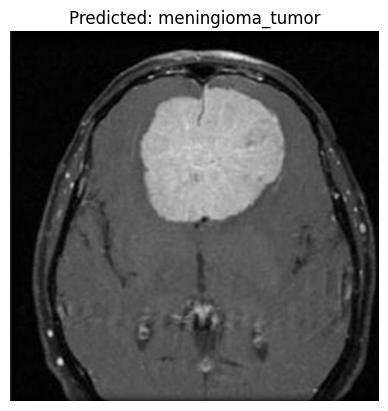

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

###########################################################
# 1) Define your LeNet5_512_Dropout architecture
###########################################################
class LeNet5_512_Dropout(nn.Module):
    def __init__(self, dropout_p=0.5, num_classes=4):
        """
        A LeNet-5-inspired network for 512x512 RGB images, with dropout layers.
        """
        super(LeNet5_512_Dropout, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool = nn.AvgPool2d(kernel_size=2)

        # For 512×512 input => after two (conv + pool) => shape is (16×125×125) => 250,000 features
        self.fc1 = nn.Linear(16 * 125 * 125, 120)
        self.drop1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(120, 84)
        self.drop2 = nn.Dropout(p=dropout_p)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # => (6×508×508)
        x = self.pool(x)           # => (6×254×254)
        
        x = F.relu(self.conv2(x))   # => (16×250×250)
        x = self.pool(x)           # => (16×125×125)
        
        x = x.view(x.size(0), -1)   # flatten => 16*125*125 = 250,000
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        return x

###########################################################
# 2) Function to load the model from .pth
###########################################################
def load_model(pth_file, device, dropout_p=0.5, num_classes=4):
    """
    1) Creates an instance of LeNet5_512_Dropout with the specified dropout/classes.
    2) Loads the state dict from `pth_file`.
    3) Moves model to `device`.
    4) Returns the model in eval mode.
    """
    model = LeNet5_512_Dropout(dropout_p=dropout_p, num_classes=num_classes)
    state_dict = torch.load(pth_file, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model

###########################################################
# 3) Single-image prediction function
###########################################################
def predict_single_image(model, image_path, device, transform, class_names):
    """
    1) Opens the image at `image_path`.
    2) Applies `transform`.
    3) Runs a forward pass through `model`.
    4) Prints & shows the predicted class.
    """
    # Load and transform the image
    img = Image.open(image_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted_idx = torch.max(outputs, dim=1)

    predicted_label = predicted_idx.item()
    predicted_class = class_names[predicted_label]

    print(f"Image: {image_path}")
    print(f"Predicted class: {predicted_class}")

    # Display image with prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis("off")
    plt.show()

    return predicted_class

###########################################################
# 4) Main script
###########################################################
if __name__ == "__main__":
    # Choose device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Same mean & std as in training transforms (adjust if needed)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inference_transform = transforms.Compose([
        transforms.Resize((512, 512)),  # match your training image size
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Class names (adjust order if different)
    class_names = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

    # Path to your saved .pth file
    pth_file = "best_model.pth"

    # Load the model
    model = load_model(pth_file, device, dropout_p=0.5, num_classes=4)

    # Path to your image (e.g., 'Untitled.jpg')
    image_path = "Untitled.png"

    # Predict
    predict_single_image(model, image_path, device, inference_transform, class_names)


In [19]:
import torch

# 1) Define your model architecture from training
class MyModelClass(nn.Module):
    def __init__(self, num_classes=4):
        super(MyModelClass, self).__init__()
        # ... define layers (Conv2d, Pool, Linear, etc.) ...
        pass

    def forward(self, x):
        # ...
        pass

# 2) If you used the same transforms as your training pipeline, define them here:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
inference_transform = transforms.Compose([
    transforms.Resize((512, 512)),     # or whatever size you used in training
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

class_names = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 3) Load the model
    pth_file = "best_model.pth"  # your .pth file path
    model = load_model(pth_file, MyModelClass, device)

    # 4) Predict on an untitled image
    image_path = "Untitled.jpg"  # or any path to your 'untitled' image
    predict_single_image(model, image_path, device, inference_transform, class_names)


C:\Users\yonat\AppData\Local\Temp\ipykernel_21244\1012807206.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pth_file, map_location=device)


RuntimeError: Error(s) in loading state_dict for MyModelClass:
	Unexpected key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "fc3.weight", "fc3.bias". 